In [71]:
import pandas as pd 
import numpy as np
from pandas_datareader import data as pdr

import yfinance as yf #yahoo finance stock data
import datetime
import matplotlib.pyplot as plt
from math import sqrt

import tensorflow as tf
from tensorflow import keras

from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn import tree

from keras.models import Sequential
from keras.layers import Activation,Dropout,Dense,LSTM,BatchNormalization

stock="^GSPC"

In [2]:
min=yf.download(tickers=stock,period="3d",interval="1m")
thirt_min=yf.download(tickers=stock,period="60d", interval="30m")
hour=yf.download(tickers=stock,period="150d",interval="1h")
daily=yf.download(tickers=stock,period="1000d",interval="1d")
weekly=yf.download(tickers=stock,period="3800d",interval="1wk")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [109]:
def Prepare_dataset(df,data_size=255,forecast_window=1):
    from sklearn.model_selection import train_test_split

    df.dropna(inplace=True,how="all",axis=0)
    df.fillna(inplace=True,method="ffill")
    df=df.iloc[-data_size:]
    y=df.shift(-forecast_window).iloc[:-forecast_window,3].values
    X=df.drop(["Adj Close","Close"],1)
    X=X.iloc[:-forecast_window,:]
    return train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

def Mape(y,y_pred):
    mape=np.mean(np.abs((y-y_pred)/y))*100
    return "{:.0%}".format(mape)

def Rmse(y,y_pred):
    return np.sqrt(((y_pred - y) ** 2).mean())

def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std


def Arima_build(ts_train,ts_test):
  global arima_model
  def arimamodel(timeseriesarray):
    import pmdarima as pmd
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1,
                              max_p=5,
                              start_q=1,
                              max_q=5,
                              test="adf",
                              max_order=5,
                              seasonal_test="OCSB",
                              stepwise=False,
                              n_jobs=-1,
                              trace=True)
    return autoarima_model

  arima_model = arimamodel(ts_train)
  preds=arima_model.predict(len(ts_test))
  return ts_test

def plot_history(history):
    hist=pd.DataFrame(history.history)
    hist["epoch"]=history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error")
    plt.plot(hist.epoch,hist.mae,label="Train error")
    plt.plot(hist.epoch,hist.val_mae,label="Val error")
    plt.legend()
    plt.ylim([0,hist.mae.max()])

def Build_lstm(X_train,X_test,y_train,scale=True):
    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph() 

    global lstm_model

    if scale==True:     
        x_scaler = StandardScaler()
        X_train=x_scaler.fit_transform(X_train)
        X_test=x_scaler.transform(X_test)
        
    x_train=np.array(X_train).reshape(X_train.shape[0],X_train.shape[1],1)
    x_test=np.array(X_test).reshape(X_test.shape[0],X_test.shape[1],1)

    lstm_model = Sequential()
    lstm_model.add(LSTM(64,return_sequences=True))
    lstm_model.add(LSTM(128,return_sequences=False))
    lstm_model.add(Dense(units=32))
    lstm_model.add(Dense(units=1))


    lstm_model.compile(loss="mse",optimizer="nadam",metrics=['accuracy'])
    lstm_model.fit(x_train, np.array(y_train), epochs=1000,verbose=0,batch_size=32)
    preds=lstm_model.predict(x_test, batch_size=1)

    return preds



In [110]:
datasets={}
datasets["1m"]=Prepare_dataset(min,forecast_window=1)
datasets["30m"]=Prepare_dataset(thirt_min,forecast_window=1)
datasets["1h"]=Prepare_dataset(hour,forecast_window=1)
datasets["D"]=Prepare_dataset(daily,forecast_window=1)
datasets["W"]=Prepare_dataset(weekly,forecast_window=1)

In [111]:
mape=pd.DataFrame(columns=["1m","30m","1h","D","W"])
rmse=pd.DataFrame(columns=["1m","30m","1h","D","W"])

arima_models={}
elastic_nets={}
rf_models={}
ltsm_models={}

preds={}

for key in datasets:
    X_train=datasets[key][0]
    X_test=datasets[key][1]
    y_train=datasets[key][2]
    y_test=datasets[key][3]

    elastic=ElasticNet().fit(X_train, y_train)
    elastic_preds=elastic.predict(X_test)
    mape.loc["Elastic net",key]=[Mape(y_test,elastic_preds)]
    rmse.loc["Elastic net",key]=[Rmse(y_test,elastic_preds)]
    elastic_nets[key]=elastic

    rf=RandomForestRegressor(n_estimators=100,max_depth=4,random_state=0).fit(X_train, y_train)
    rf_preds=rf.predict(X_test)
    mape.loc["Random forest",key]=[Mape(y_test,rf_preds)]
    rmse.loc["Random forest",key]=[Rmse(y_test,rf_preds)]
    rf_models[key]=rf

    arima_preds=Arima_build(datasets[key][0]["Open"],datasets[key][1]["Open"]).values
    mape.loc["ARIMA",key]=[Mape(y_test,arima_preds)]
    rmse.loc["ARIMA",key]=[Rmse(y_test,arima_preds)]
    arima_models[key]=arima_model

    lstm_preds=Build_lstm(X_train,X_test,y_train) 
    mape.loc["LSTM scaled",key]=[Mape(y_test,lstm_preds)]
    rmse.loc["LSTM scaled",key]=[Rmse(y_test,lstm_preds)]
    ltsm_models[key]=lstm_model

    preds[key]=[arima_preds,elastic_preds,rf_preds,lstm_preds]

    print(f"Model for {key} dataset is done")
rmse,mape

Total fit time: 0.735 seconds
Model for 1m dataset is done
Total fit time: 0.981 seconds
Model for 30m dataset is done
Total fit time: 0.967 seconds
Model for 1h dataset is done
Total fit time: 1.134 seconds
Model for D dataset is done
Total fit time: 1.195 seconds
Model for W dataset is done


(                                 1m                   30m  \
 Elastic net    [0.9447957030564399]   [8.606475403832999]   
 Random forest  [0.9994833510089518]  [26.161437588412685]   
 ARIMA          [0.8912628633552628]  [10.047285873219165]   
 LSTM scaled     [2.075804620775169]  [35.512098022596405]   
 
                                  1h                     D  \
 Elastic net    [12.062569472163371]   [50.31336328765257]   
 Random forest   [41.91429248898837]   [78.65620021804703]   
 ARIMA          [13.590100243481514]   [51.22795679342295]   
 LSTM scaled    [47.486438444231844]  [150.93022760972127]   
 
                                   W  
 Elastic net    [123.93195345706766]  
 Random forest  [225.39902777615794]  
 ARIMA            [156.689202065301]  
 LSTM scaled     [367.2076448654866]  ,
                  1m    30m      1h       D       W
 Elastic net    [2%]  [19%]   [23%]  [117%]  [299%]
 Random forest  [2%]  [62%]   [94%]  [176%]  [552%]
 ARIMA          [2%]  [1

In [115]:
rmse

,1m,30m,1h,D,W
Elastic net,[0.9447957030564399],[8.606475403832999],[12.062569472163371],[50.31336328765257],[123.93195345706766]
Random forest,[0.9994833510089518],[26.161437588412685],[41.91429248898837],[78.65620021804703],[225.39902777615794]
ARIMA,[0.8912628633552628],[10.047285873219165],[13.590100243481514],[51.22795679342295],[156.689202065301]
LSTM scaled,[2.075804620775169],[35.512098022596405],[47.486438444231844],[150.93022760972127],[367.2076448654866]


In [116]:
mape

,1m,30m,1h,D,W
Elastic net,[2%],[19%],[23%],[117%],[299%]
Random forest,[2%],[62%],[94%],[176%],[552%]
ARIMA,[2%],[17%],[25%],[118%],[368%]
LSTM scaled,[4%],[87%],[109%],[354%],[931%]


No handles with labels found to put in legend.


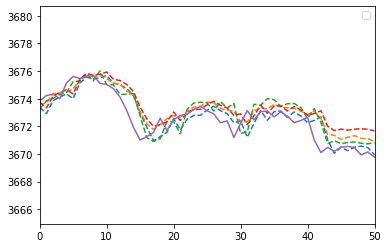

In [64]:
plt.ylim(preds['1m'][0].min()-5,preds['1m'][0].max()+5)
plt.xlim(0,50)
plt.plot(preds['1m'][0], linestyle='dashed')
plt.plot(preds['1m'][1], linestyle='dashed')
plt.plot(preds['1m'][2], linestyle='dashed')
plt.plot(preds['1m'][3], linestyle='dashed')
plt.legend()
plt.plot(datasets['1m'][3])

In [ ]:
plt.ylim(preds['W'][0].min()-5,preds['1m'][0].max()+5)
plt.xlim(0,50)
plt.plot(preds['W'][3], linestyle='dashed')

plt.legend()
plt.plot(datasets['W'][3])

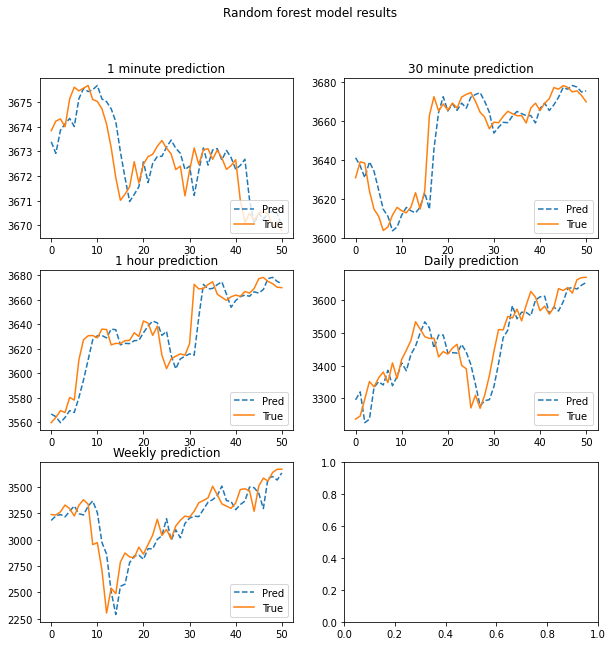

In [158]:
m=0

fig, axs = plt.subplots(3, 2,figsize=(10,10))
fig.suptitle('Random forest model results')

axs[0, 0].set_title('1 minute prediction')
axs[0,0].plot(preds['1m'][m], linestyle='dashed',label="Pred")
axs[0,0].plot(datasets['1m'][3],label="True")
axs[0,0].legend(loc="lower right")

axs[0, 1].set_title('30 minute prediction')
axs[0,1].plot(preds['30m'][m], linestyle='dashed',label="Pred")
axs[0,1].plot(datasets['30m'][3],label="True")
axs[0,1].legend(loc="lower right")

axs[1, 0].set_title('1 hour prediction')
axs[1,0].plot(preds['1h'][m], linestyle='dashed',label="Pred")
axs[1,0].plot(datasets['1h'][3],label="True")
axs[1,0].legend(loc="lower right")

axs[1, 1].set_title('Daily prediction')
axs[1,1].plot(preds['D'][m], linestyle='dashed',label="Pred")
axs[1,1].plot(datasets['D'][3],label="True")
axs[1,1].legend(loc="lower right")

axs[2, 0].set_title('Weekly prediction')
axs[2,0].plot(preds['W'][m], linestyle='dashed',label="Pred")
axs[2,0].plot(datasets['W'][3],label="True")
axs[2,0].legend(loc="lower right")

In [17]:
plot_preds(key):
    preds[key][0]

array([3673.38989258, 3672.91992188, 3673.86010742, 3674.12011719,
       3674.34008789, 3674.01000977, 3675.13989258, 3675.56005859,
       3675.42993164, 3675.51000977, 3675.67993164, 3675.12988281,
       3675.02001953, 3674.72998047, 3674.20996094, 3672.97998047,
       3671.92993164, 3670.95996094, 3671.25      , 3671.56005859,
       3672.57006836, 3671.72998047, 3672.51000977, 3672.79003906,
       3672.80004883, 3673.16992188, 3673.45996094, 3673.12988281,
       3672.91992188, 3672.26000977, 3672.39990234, 3671.20996094,
       3672.20996094, 3673.13989258, 3672.43994141, 3673.06005859,
       3673.11010742, 3672.64990234, 3673.04003906, 3672.75      ,
       3672.27001953, 3672.42993164, 3672.67993164, 3671.0300293 ,
       3670.05004883, 3670.48999023, 3670.23999023, 3670.47998047,
       3670.57006836, 3670.4699707 , 3669.94995117])

In [11]:
arima_models["1m"],arima_models["30m"],arima_models["1h"],arima_models["D"],arima_models["W"]

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(1, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1)))

In [12]:
#train = data[:training_data_len]
#valid = data[training_data_len:]
#valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price' ,fontsize=18)
plt.plot(daily['Close'],linewidth=3.5)
#plt.plot(datasets["W"][1].index,preds["W"][0],linewidth=3.5)
#plt.plot(datasets["W"][1].index,preds["W"][1],linewidth=3.5)
#plt.plot(datasets["W"][1].index,preds["W"][2],linewidth=3.5)
plt.plot(datasets["D"][1].index,preds["D"][3],linewidth=3.5)
plt.legend(['Train','Predictions'], loc='upper_center')

ValueError: Unrecognized location 'upper_center'. Valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
